# Importing libraries and functions

Importing required libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import os
import sys



In [3]:
def make_dir(path): # Function to make adirectory to save files in
    cwd = os.getcwd()
    abs_path = cwd + path


    if not os.path.exists(abs_path):
        try: 
            os.makedirs(abs_path)
            print(abs_path)
        except OSError:return 0
        else: return 1
    else: return 2

In [4]:
def get_APE(pred,y_true):
    APE = np.zeros(y_true.shape[0])
    for i in range(y_true.shape[0]):
        APE[i] = abs((pred[i] - y_true[i]) / y_true[i])

    return APE

def get_max_APE(APE):
    max_APE = np.zeros(1)

    for i in range(30,172):
        if APE[i] > max_APE:
            max_APE = APE[i]
    return max_APE

In [5]:
def load_optimizers(): # Function to load all optimizers
    Adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.001,
                                            rho=0.95, epsilon=1e-07)
    RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    Adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.01)
    SGD_NM = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5, nesterov=True)
    Adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    Nadam = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

    opti_list = [RMSprop, Adadelta, Adagrad, SGD_NM, Adam, Nadam]
    opti_name_list = ["RMSprop", "Adadelta", "Adagrad", "SGD_NM", "Adam", "Nadam"]

    return opti_list, opti_name_list

In [6]:
# Declaring Variables
num_epochs = 200000
save_dir = 'PostProc/IndVal/OptiStudies/'
model_max_load_dir = 'PostProc/MaxVal/OptiStudies/model_Adam'

# Hyper Parameters for Neural Network 
loss_ind = "mean_squared_error"
metrics_ind = ["mape"]




In [7]:
# Reading data from .csv file
data_dat = pd.read_csv (r'data.csv')
pred_dat = pd.read_csv (r'test.csv')

In [8]:
# Extracting data into numpy arrays from pandas DataFrames

# Training data
X = pd.DataFrame(data_dat, columns = ['LD'])
X = X.to_numpy()

X_n = pd.DataFrame(data_dat, columns = ['XL'])
X_n = X_n.to_numpy()


y = pd.DataFrame(data_dat, columns = ['Ma'])
y = y.to_numpy()

# Prediction data
X_pred = pd.DataFrame(pred_dat, columns = ['LD'])
X_pred = X_pred.to_numpy()
X_pred_ns = X_pred

X_n_pred = pd.DataFrame(pred_dat, columns = ['XL'])
X_n_pred = X_n_pred.to_numpy()

y_pred = pd.DataFrame(pred_dat, columns = ['Ma'])
y_pred = y_pred.to_numpy()



In [9]:
# Returns normalised valeus of Mach Number and Maximum Mach Number per L/D ratio as two arrays

def get_norm_y(y,c): 
    num = int(y.shape[0] / c)
    max_val = np.zeros(num)
    y_norm = np.zeros([num*c])
    for i in range(num):
        max_val[i] = max(y[i*c:(i+1)*c])
        for j in range(c):
            y_norm[i*c + j] = y[i*c+j]/max_val[i]
    return y_norm, max_val
    
y_norm, max_y = get_norm_y(y, 201)
y_pred_norm, y_pred_max = get_norm_y(y_pred, 201)

# Returns Input set fro training the Max Mach Numbers

def get_x(x,c):
    num = int(x.shape[0]/c)
    x_n = np.zeros([num])
    
    for i in range(num):
        x_n[i] = x[i*c]
    
    return x_n

X_max = get_x(X,201)
X_pred_max = get_x(X_pred, 201)

X= np.hstack((X_n,X))
X_pred = np.hstack((X_n_pred,X_pred))

In [10]:
print(X_pred_max)

[ 6.   6.5  7.5  8.   8.5 10.   5.   4.   4.5  3.   9. ]


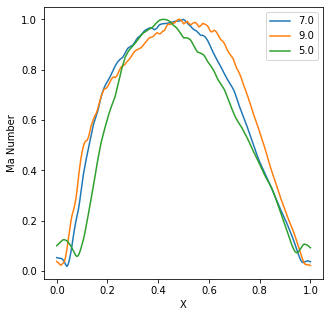

In [11]:
# Plot the values of normalised Mach Numbers of training set

fig2 = plt.figure()
for i in range(max_y.shape[0]):
    plt.plot(X_n[:201],y_norm[i*201:(i+1)*201], label=str(X_max[i]))

plt.xlabel("X")
plt.ylabel("Ma Number")
# plt.title('%s Loss Function for %s epochs \n Prediction vs Actual' %(loss_func_name, str(num_epochs)))
plt.legend(loc="upper right")
fig = plt.gcf()
fig.set_size_inches(5, 5)
# plt.savefig(save_dir + '%s_pred_%s.png' %(loss_func_name, str(num_epochs)), dpi=500)
plt.show()
plt.close(fig2)

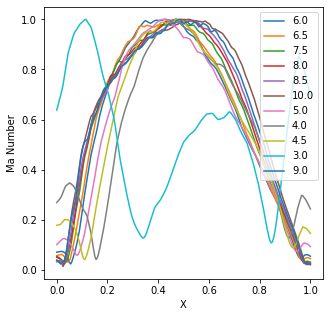

In [12]:
# Plot the values of normalised Mac Numbers of predict set

fig2 = plt.figure()
for i in range(X_pred_max.shape[0]):
    plt.plot(X_n_pred[:201],y_pred_norm[i*201:(i+1)*201], label=str(X_pred_max[i]))

plt.xlabel("X")
plt.ylabel("Ma Number")
# plt.title('%s Loss Function for %s epochs \n Prediction vs Actual' %(loss_func_name, str(num_epochs)))
plt.legend(loc="upper right")
fig = plt.gcf()
fig.set_size_inches(5, 5)
# plt.savefig(save_dir + '%s_pred_%s.png' %(loss_func_name, str(num_epochs)), dpi=500)
plt.show()
plt.close(fig2)

# Training for Individual Points for final value

DONOT RUN THIS IF YOU DONOT WANT TO RETRAIN THE MODEL

In [12]:
val_makedir = make_dir('/'+save_dir)

if val_makedir == 1:
    print('Directory has been created')
elif val_makedir == 2:
    print('Directory already exists')
else:
    print('Failed to create directory')
    sys.exit(0)

Directory already exists


In [13]:
##### Using sklearn to split the data into train and test sets with shuffling ####
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.2, random_state=42, shuffle=True)


<Figure size 432x288 with 0 Axes>

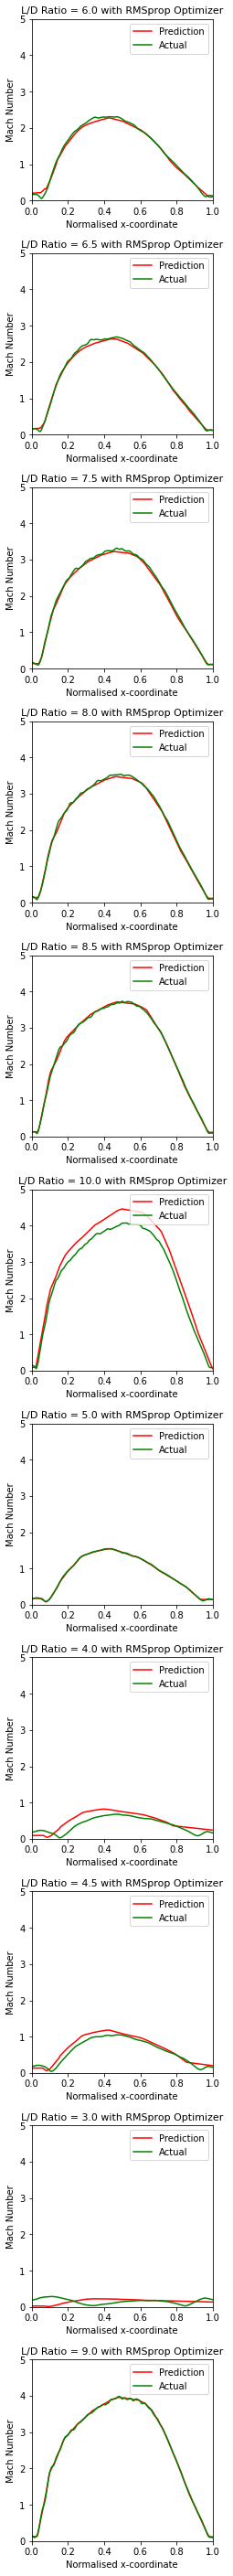

<Figure size 432x288 with 0 Axes>

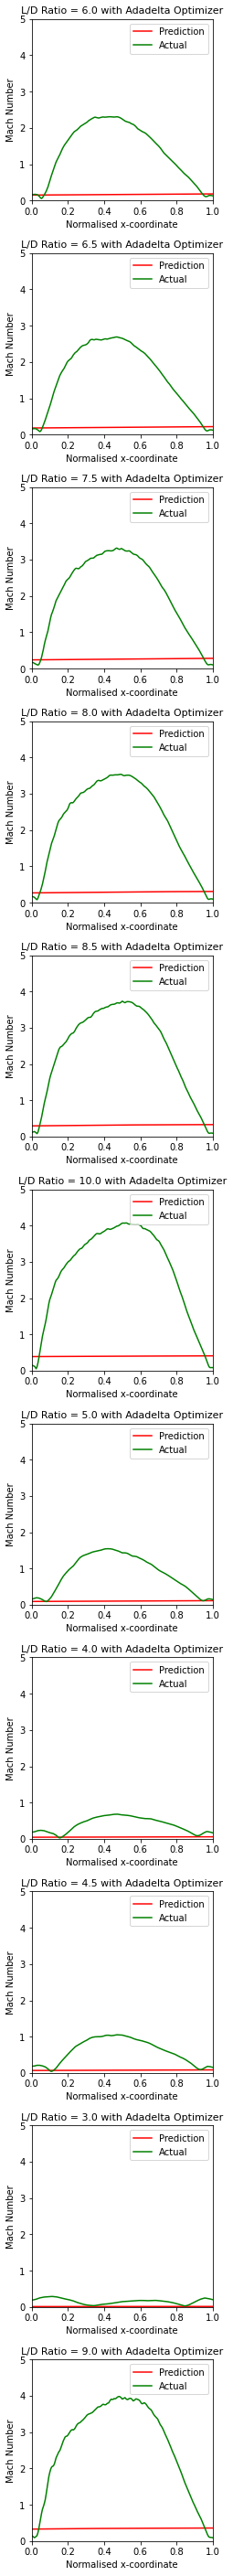

<Figure size 432x288 with 0 Axes>

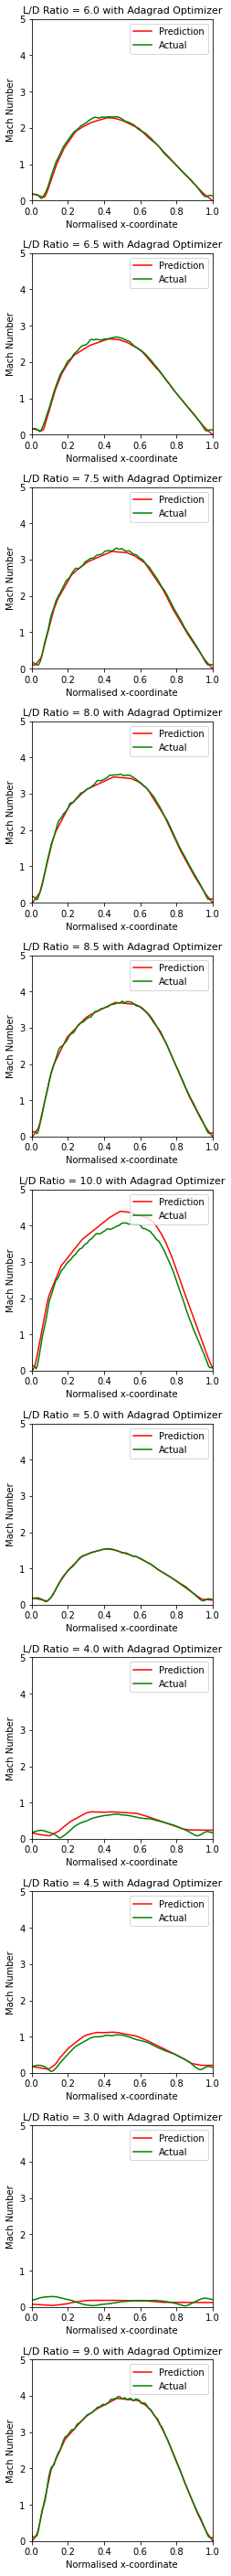

<Figure size 432x288 with 0 Axes>

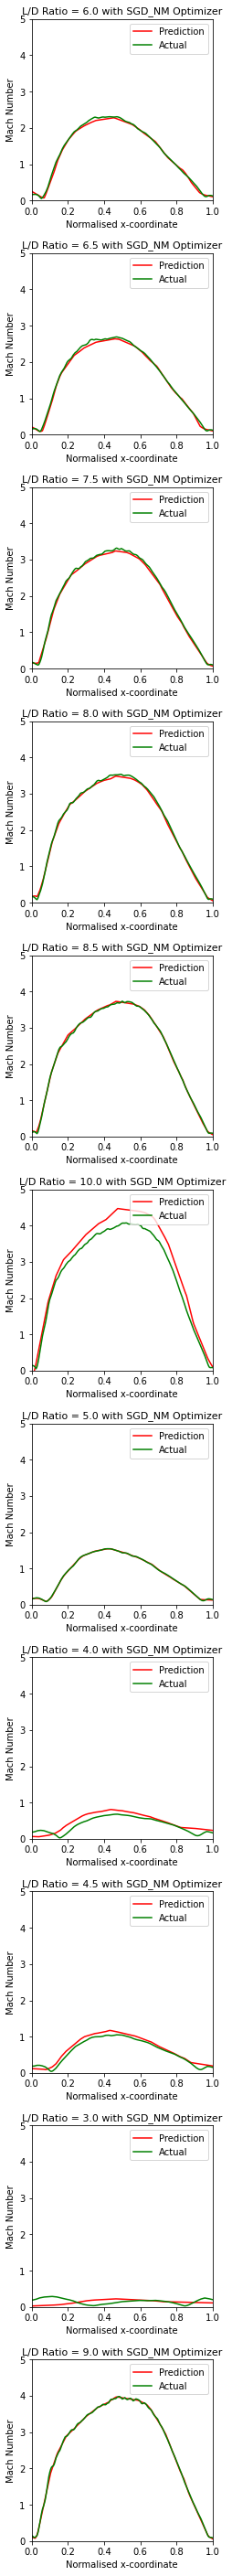

<Figure size 432x288 with 0 Axes>

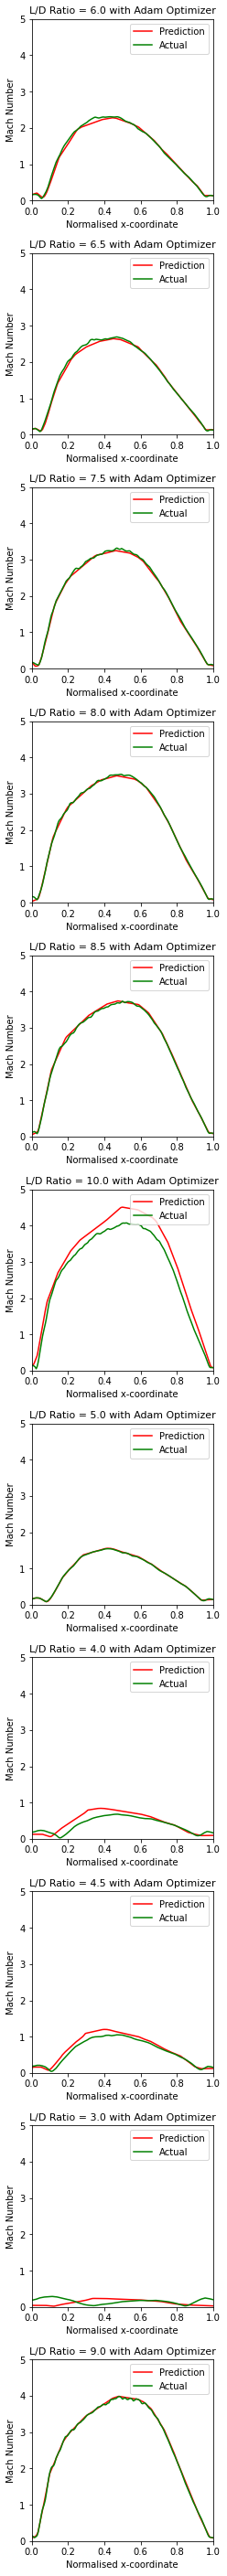

<Figure size 432x288 with 0 Axes>

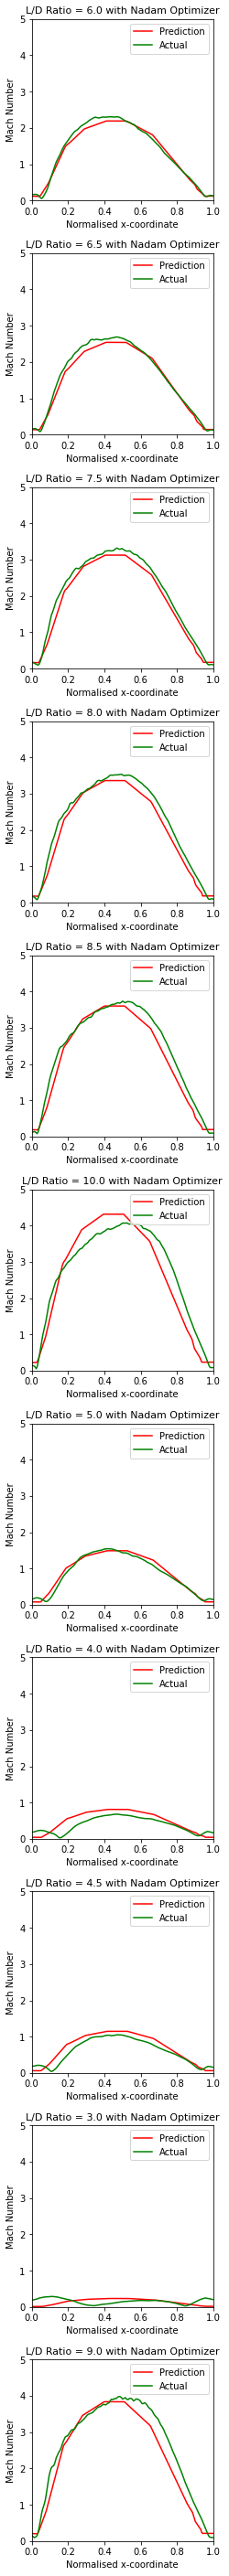

In [19]:
opti_list, opti_name_list = load_optimizers()
max_MAPE=np.zeros([len(opti_list), X_pred_max.shape[0]])
for i in range(len(opti_list)):
    opti = opti_list[i]
    opti_name = opti_name_list[i]
    
    # Filepaths for saving Model Checkpoints:
    save_model_path = save_dir+'model_'+opti_name
    
    """early_stopping_callback = EarlyStopping(monitor='val_'+metrics_ind[0], 
                                        patience=500,
                                        min_delta= 1e-7,
                                        restore_best_weights=True,
                                        mode='auto')
    checkpoint_callback = ModelCheckpoint(filepath=save_model_path,
                                          monitor='val_'+metrics_ind[0],
                                          verbose=1,
                                          save_weights_only=False,
                                          save_best_only=True,
                                          mode='auto')    
    #### Load Model
    model = Sequential([
                Dense(5, activation = 'relu', input_shape=X_train[0].shape),
                Dense(20, activation = 'relu'),
                Dense(50, activation = 'relu'),
                Dense(20, activation = 'relu'),
                Dense(5, activation = 'relu', input_shape=X_train[0].shape),
                Dense(1, activation = 'linear')
            ])

    print(model.summary())
    
    # Compiling the model
    model.compile(loss=loss_ind, optimizer=opti, metrics=metrics_ind)
    
    # Training the net on training data
    history = model.fit(X_train,
                        y_train,
                        batch_size=3,
                        epochs=num_epochs,
                        verbose=0,
                        validation_data=(X_test,y_test),
                        callbacks=[early_stopping_callback])
    model.save(save_model_path)
    
    model_data = pd.DataFrame(history.history)
    model_data.head()
    """
    
    # Get predictions for both Max and Ind
    model_max = load_model(model_max_load_dir)
    model = load_model(save_model_path)
    pred_max = model_max.predict(X_pred_max)
    y_ind_pred = model.predict(X_pred)

    """nrows = 2
    ncols = 2 
    # Initialise the plot
    fig1 = plt.figure()
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(16,8)
    # Plot loss in [0,0]
    loss_plot=model_data.plot(y="loss", title ="Loss vs Epochs", ax=axes[0,0])
    loss_plot.set(xlabel="Epochs", ylabel="Loss")
    # Plot MSE in [0,1]
    mse_plot=model_data.plot(y="mape", title ="MAPE vs Epochs", ax=axes[0,1])
    mse_plot.set(xlabel="Epochs", ylabel="MSE")
    # Plot val_loss in [1,0]
    val_loss_plot=model_data.plot(y="val_loss", title ="Validation Loss vs Epochs", ax= axes[1,0])
    val_loss_plot.set(xlabel="Epochs", ylabel="Validation Loss")
    # Plot val_mse in [1,1]
    val_mse_plot=model_data.plot(y="val_"+ metrics_ind[0], title ="Validation MAPE vs Epochs", ax= axes[1,1])
    val_mse_plot.set(xlabel="Epochs", ylabel="Validation MAPE")
    # Subplot properties
    plt.suptitle("%s Optimizer " %(opti_name)) # Subplot title
    plt.subplots_adjust(wspace=0.25, hspace=0.8) # Spacing details
    plt.savefig(save_dir + '%s_stats.png' %(opti_name), dpi=500)
    plt.show(fig1)
    plt.close(fig1)"""
    
    
    nrows=X_pred_max.shape[0]
    fig3 = plt.figure()
    fig, axes = plt.subplots(nrows)
    fig.set_size_inches(6,39)
    for j in range(nrows):
        axes[j].plot(X_n_pred[:201],
                      y_ind_pred[j*201:(j+1)*201]*pred_max[j],
                      'r',
                      label='Prediction')
        axes[j].plot(X_n_pred[j*201:(j+1)*201], y_pred[j*201:(j+1)*201], 'g', label='Actual')
        axes[j].set(xlabel="Normalised x-coordinate", ylabel="Mach Number")
        axes[j].set_title('L/D Ratio = %.1f with %s Optimizer' %(X_pred_max[j], opti_name), fontsize=11)
        axes[j].legend(loc="upper right")
        axes[j].set_xlim((0,1))
        axes[j].set_ylim((0,5))
        axes[j].set_aspect(0.2)
    
    fig = plt.gcf()
    plt.tight_layout(pad=0.25, h_pad=1.25, w_pad=0.25, rect=None)
    plt.savefig(save_dir + 'cumilative_ind_%s_predictions.png' %(opti_name), dpi=500)
    plt.show(fig3)
    plt.close(fig3)

    pred = np.zeros(y_ind_pred.shape)
    for j in range(pred_max.shape[0]):
        for k in range(201):
            pred[j*201+k] = y_ind_pred[j*201+k]*pred_max[j]
            
    pred_APE = get_APE(pred, y_pred)
    
    for j in range(X_pred_max.shape[0]):
        max_MAPE[i,j] = get_max_APE(pred_APE[j*201:(j+1)*201])*100

    

    del(model)

In [20]:
temp = np.zeros([max_MAPE.shape[0],1])
for i in range(max_MAPE.shape[0]):
    temp[i,0] = np.mean(max_MAPE[i,:])
max_MAPE_n = np.hstack((max_MAPE,temp))
print(max_MAPE_n)

[[   6.48540609    5.54284388    5.47872827    7.13034629    5.82234034
    19.43595875    3.72800389  948.52130887   75.31212823  513.37839554
     1.37775266  144.74665571]
 [  93.01197289   92.64061306   92.10979452   91.74122582   91.34398996
    90.12255252   93.41257551   92.46046771   92.78456836   95.32969603
    91.21840185   92.37962348]
 [   6.94198861    5.67183328    4.36865124    6.03099754    5.39359144
    20.43331184    5.9081784   727.47208671   61.18442856  396.06395264
     2.50045291  112.90631574]
 [   7.06921004    5.35755856    4.29601552    3.87849985    3.58971556
    24.52291246    2.40912523  706.91313684   53.46410374  416.83298039
     2.58675509  111.90181939]
 [   7.53640272    6.63752227    4.48188162    4.62009874    4.64958541
    23.02373374    2.03047264  808.20230893   59.48401268  543.34336918
     2.90663762  133.35600232]
 [   9.48599724   15.47491548   17.10231625   20.1533643    24.03992651
    32.32547314   26.5309249  1317.46233001  137.2057

In [21]:
column_df = []
for i in range(X_pred_max.shape[0]):
    column_df.append(str(X_pred_max[i]))
column_df.append("Mean")


MAPE_df = pd.DataFrame(max_MAPE_n, 
                       index=opti_name_list, 
                       columns=column_df)

MAPE_df.to_csv(save_dir + 'Cumilative_max_MAPE.csv', index=True, header=True, sep=',')

In [17]:
print(get_max_APE(pred_APE[:201]))

1.1316287938773022


In [24]:
print(X_pred_max,y_pred_max)

[ 6.   6.5  7.5  8.   8.5 10.   5.   4.   4.5  3.   9. ] [2.30821  2.6897   3.32111  3.53529  3.73497  4.07276  1.54621  0.680298
 1.05127  0.290142 3.98238 ]
